# gpOptimizer Multi-Task Test
At first we have to install the newest version of gpCAM

In [1]:
##first install the newest version of fvgp
#!pip install gpCAM==8.0.3

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import fvGPOptimizer
import plotly.graph_objects as go
from itertools import product

%load_ext autoreload
%autoreload 2

## Simple 1d Example

### Data

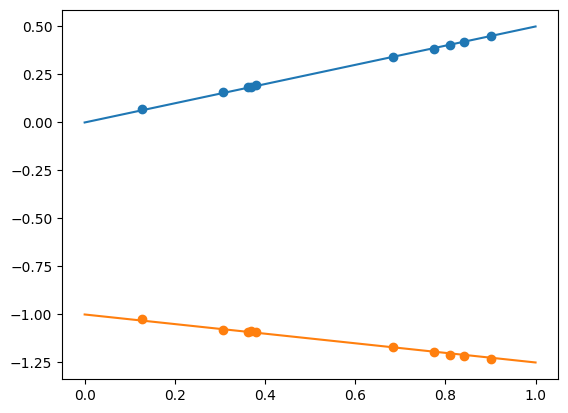

In [3]:
def f1(x): return 0.5 * x
def f2(x): return (-.25 * x) - 1.

x_pred1d = np.linspace(0,1,50)
plt.plot(x_pred1d,f1(x_pred1d))
plt.plot(x_pred1d,f2(x_pred1d))
x_data = np.random.rand(10)
y_data1 = f1(x_data) + np.random.uniform(low = -0.01, high = 0.01, size =len(x_data))
y_data2 = f2(x_data) + np.random.uniform(low = -0.01, high = 0.01, size =len(x_data))
plt.scatter(x_data,y_data1) 
plt.scatter(x_data,y_data2) 
plt.show()

### GP initialization

In [4]:
my_gp2 = fvGPOptimizer(x_data.reshape(len(x_data),1), np.column_stack([y_data1, y_data2]), info = False)
print("Hybrid Training in progress")
my_gp2.train(max_iter = 20, method = "hgdl")

print("MCMC Training in progress")
my_gp2.train(max_iter = 20, method = "mcmc")

print("Local Training in progress")
my_gp2.train(max_iter = 20, method = "local")

print("Local Training in progress")
my_gp2.train(max_iter = 20)

/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/fvgp/gp.py:278: UserWarning: No noise function or measurement noise provided. Noise variances will be set to 1% of mean(y_data).
  self.likelihood = GPlikelihood(self.data.x_data,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/fvgp/gp.py:469: UserWarning: Default hyperparameter_bounds initialized because none were provided. This will fail for custom kernel, mean, or noise functions
  warnings.warn("Default hyperparameter_bounds initialized because none were provided. "


Hybrid Training in progress


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:95: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:95: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:95: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,


MCMC Training in progress
Local Training in progress
Local Training in progress


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/fvgp/gp.py:469: UserWarning: Default hyperparameter_bounds initialized because none were provided. This will fail for custom kernel, mean, or noise functions
  warnings.warn("Default hyperparameter_bounds initialized because none were provided. "
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/fvgp/gp_training.py:331: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  OptimumEvaluation = minimize(


### Predictions

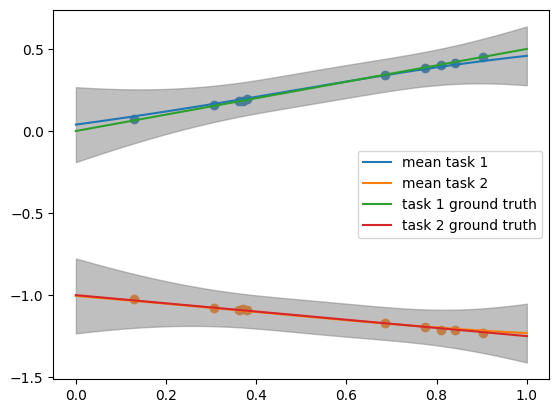

In [5]:
#mean and standard deviation
mean = my_gp2.posterior_mean(x_pred=x_pred1d.reshape(50,1), x_out=np.array([0,1]))["f(x)"]
std = np.sqrt(my_gp2.posterior_covariance(x_pred=x_pred1d.reshape(50,1), x_out=np.array([0,1]))["v(x)"])

plt.plot(x_pred1d.reshape(50,1),mean[:,0], label = "mean task 1")
plt.plot(x_pred1d.reshape(50,1),mean[:,1], label = "mean task 2")
plt.scatter(x_data,y_data1) 
plt.scatter(x_data,y_data2) 
plt.plot(x_pred1d,f1(x_pred1d), label = "task 1 ground truth")
plt.plot(x_pred1d,f2(x_pred1d), label = "task 2 ground truth")
plt.fill_between(x_pred1d, mean[:,0] - 3. * std[:,0], mean[:,0] + 3. * std[:,0], alpha = 0.5, color = "grey")
plt.fill_between(x_pred1d, mean[:,1] - 3. * std[:,1], mean[:,1] + 3. * std[:,1], alpha = 0.5, color = "grey")
plt.legend()
plt.show()

In [6]:
#asking for the best candidate:
my_gp2.ask([np.array([0.0]), np.array([0.2]), np.array([1.])], x_out = np.array([0,1]), n=2)

{'x': array([[0.],
        [1.]]),
 'f(x)': array([0.01156126, 0.00711827]),
 'opt_obj': None}

In [7]:
#asking for an optimized result
my_gp2.ask(np.array([[0.,1.]]), x_out = np.array([0,1]), n=2, method = "hgdl")

/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:95: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:95: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:95: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,


{'x': array([[0.],
        [0.]]),
 'f(x)': array([0.01156126, 0.01156126]),
 'opt_obj': <hgdl.hgdl.HGDL at 0x7f3ef9ad8940>}

In [8]:
#more ask()s to test:
my_gp2.ask(np.array([[0.,1.]]), n = 1, acquisition_function = 'relative information entropy set', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0.,1.]]), n = 1, acquisition_function = 'relative information entropy', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0.,1.]]), n = 1, acquisition_function = 'variance', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0.,1.]]), n = 1, acquisition_function = 'total correlation', x_out = np.array([0.,1.,2.]), vectorized = True)

my_gp2.ask(np.array([[0.,1.]]), n = 4, acquisition_function = 'relative information entropy set', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0.,1.]]), n = 5, acquisition_function = 'relative information entropy', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0.,1.]]), n = 6, acquisition_function = 'variance', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0.,1.]]), n = 2, acquisition_function = 'total correlation', x_out = np.array([0.,1.,2.]), vectorized = True)


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,
/home/marcus/Coding/gpCAM/gpcam/gp_optimizer.py:1653: UserWarning: You specified n>1 and method != 'hgdl' in ask(). The acquisition function has therefore been changed to 'total correlation'.
  warnings.warn("You specified n>1 and method != 'hgdl' in ask(). The acquisition function "


{'x': array([[9.99568111e-01],
        [1.38571085e-05]]),
 'f(x)': array([-17.2506561]),
 'opt_obj': None}

## 3d Example

### Data

In [ ]:
data = np.load("./data/sim_variable_mod.npy")
sparsification = 32

x_data3 = data[:,5:][::sparsification]
y_data3 = data[:,0:3][::sparsification]

#it is good practice to check the format of the data
print(x_data3.shape)
print(y_data3.shape)

In [ ]:
x = np.linspace(30,100,100)
y = np.linspace(40,130,100)
x_pred3D = np.asarray(list(product(x, y)))
x_pred3D = np.column_stack([x_pred3D, np.zeros((len(x_pred3D),1)) + 300.])

## Plotting

In [ ]:
def scatter(x,y,z,size=3, color = 1):
    #if not color: color = z
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z,mode='markers',marker=dict(color=color, size = size)))
    
    
    fig.update_layout(autosize=False,
                  width=800, height=800,
                  font=dict(size=18,),
                  margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

In [ ]:
scatter(x_data3[:,0],x_data3[:,1],x_data3[:,2], size = 5, color = y_data3[:,0])
scatter(x_data3[:,0],x_data3[:,1],x_data3[:,2], size = 5, color = y_data3[:,1])
scatter(x_data3[:,0],x_data3[:,1],x_data3[:,2], size = 5, color = y_data3[:,2])

## A simple kernel definition
It is vital in the multi-task case to think hard about kernel design. The kernel is now a function
over X x X x T x T, where X is the input and T is the output space. Print the input into the kernel, it will have the dimensionality of this cartesian product space. The default kernel is just a Matern kernel in input and output directions. 

In [ ]:
#As imple kernel, that won't lead to good performance because its stationary
def mkernel(x1,x2,hps,obj):
    d = obj.get_distance_matrix(x1,x2)
    return hps[0] * obj.matern_kernel_diff1(d,hps[1])

## Initialization

### (a) Default behavior

In [ ]:
from fvgp import fvGP

my_gp2 = fvGPOptimizer(x_data3,y_data3, info = False)
print("Global Training in progress")
my_gp2.train(max_iter = 2)

### (b) Simple custom kernel

In [ ]:
#A simple kernel, that won't lead to good performance because it's stationary
from gpcam.gp_kernels import *
def mkernel(x1,x2,hps,obj):
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])

In [ ]:
my_gp2 = fvGPOptimizer(x_data3,y_data3, info = False,
              init_hyperparameters=np.ones((2)), gp_kernel_function=mkernel
             )
print("Global Training in progress")


bounds = np.array([[0.01,1.],[0.01,1.]])
my_gp2.train(hyperparameter_bounds=bounds,max_iter = 2)

### (c) Deep kernel

In [ ]:
from gpcam.deep_kernel_network import *
iset_dim = 4
gp_deep_kernel_layer_width = 5
n = Network(iset_dim, gp_deep_kernel_layer_width)
print(n.number_of_hps)

def deep_multi_task_kernel(x1, x2, hps, obj):  # pragma: no cover
    signal_var = hps[0]
    length_scale = hps[1]
    hps_nn = hps[2:]
    w1_indices = np.arange(0, gp_deep_kernel_layer_width * iset_dim)
    last = gp_deep_kernel_layer_width * iset_dim
    w2_indices = np.arange(last, last + gp_deep_kernel_layer_width ** 2)
    last = last + gp_deep_kernel_layer_width ** 2
    w3_indices = np.arange(last, last + gp_deep_kernel_layer_width * iset_dim)
    last = last + gp_deep_kernel_layer_width * iset_dim
    b1_indices = np.arange(last, last + gp_deep_kernel_layer_width)
    last = last + gp_deep_kernel_layer_width
    b2_indices = np.arange(last, last + gp_deep_kernel_layer_width)
    last = last + gp_deep_kernel_layer_width
    b3_indices = np.arange(last, last + iset_dim)

    n.set_weights(hps_nn[w1_indices].reshape(gp_deep_kernel_layer_width, iset_dim),
                  hps_nn[w2_indices].reshape(gp_deep_kernel_layer_width, gp_deep_kernel_layer_width),
                  hps_nn[w3_indices].reshape(iset_dim, gp_deep_kernel_layer_width))
    n.set_biases(hps_nn[b1_indices].reshape(gp_deep_kernel_layer_width),
                 hps_nn[b2_indices].reshape(gp_deep_kernel_layer_width),
                 hps_nn[b3_indices].reshape(iset_dim))
    x1_nn = n.forward(x1)
    x2_nn = n.forward(x2)
    d = get_distance_matrix(x1_nn, x2_nn)
    k = signal_var * matern_kernel_diff1(d, length_scale)
    return k


my_gp2 = fvGPOptimizer(x_data3,y_data3, info = False,
              init_hyperparameters=np.ones((n.number_of_hps+2)), gp_kernel_function=deep_multi_task_kernel
             )
print("Global Training in progress")


bounds = np.zeros((n.number_of_hps+2,2))
bounds[0] = np.array([0.001,10.])
bounds[1] = np.array([0.001,10.])
bounds[2:] = np.array([-1,1])
my_gp2.train(hyperparameter_bounds=bounds,max_iter = 2, method = "mcmc")

## Prediction

In [ ]:
mean = my_gp2.posterior_mean(x_pred3D, x_out = np.array([0.,1.,2.]))["f(x)"]
var =  my_gp2.posterior_covariance(x_pred3D, x_out = np.array([0.,1.,2.]))["v(x)"]

In [ ]:
#extract data point to compare to:
index300 = np.where(x_data3[:,2]==300.)
imageX_data = x_data3[index300]
imageY_data = y_data3[index300]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_pred3D[:,0],y=x_pred3D[:,1], z=mean[:,0],
                             mode='markers',marker=dict(color=mean[:,0], size = 5)))
fig.add_trace(go.Scatter3d(x=imageX_data[:,0], y=imageX_data[:,1] , z=imageY_data[:,0],
                           mode='markers',marker=dict(color=imageY_data[:,0], size = 5)))
fig.update_layout(autosize=False,
                  width=800, height=800,
                  font=dict(size=18,),
                  margin=dict(l=0, r=0, b=0, t=0))
fig.show()



fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_pred3D[:,0], y=x_pred3D[:,1], z=mean[:,1],
                           mode='markers',marker=dict(color=mean[:,1], size = 5)))
fig.add_trace(go.Scatter3d(x=imageX_data[:,0], y=imageX_data[:,1], z=imageY_data[:,1],
                           mode='markers',marker=dict(color=imageY_data[:,1], size = 5)))
fig.update_layout(autosize=False,
                  width=800, height=800,
                  font=dict(size=18,),
                  margin=dict(l=0, r=0, b=0, t=0))
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_pred3D[:,0], y=x_pred3D[:,1], z=mean[:,2],
                           mode='markers',marker=dict(color=mean[:,2], size = 5)))
fig.add_trace(go.Scatter3d(x=imageX_data[:,0], y=imageX_data[:,1], z=imageY_data[:,2],
                           mode='markers',marker=dict(color=imageY_data[:,2], size = 5)))
fig.update_layout(autosize=False,
                  width=800, height=800,
                  font=dict(size=18,),
                  margin=dict(l=0, r=0, b=0, t=0))
fig.show()



In [ ]:
my_gp2.ask(np.array([[0,1],[0,1],[0,1]]), n = 1, acquisition_function = 'relative information entropy set', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0,1],[0,1],[0,1]]), n = 1, acquisition_function = 'relative information entropy', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0,1],[0,1],[0,1]]), n = 1, acquisition_function = 'variance', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0,1],[0,1],[0,1]]), n = 1, acquisition_function = 'total correlation', x_out = np.array([0.,1.,2.]), vectorized = True)


my_gp2.ask(np.array([[0,1],[0,1],[0,1]]), n = 4, acquisition_function = 'relative information entropy set', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0,1],[0,1],[0,1]]), n = 5, acquisition_function = 'relative information entropy', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0,1],[0,1],[0,1]]), n = 6, acquisition_function = 'variance', x_out = np.array([0.,1.,2.]), vectorized = True)
my_gp2.ask(np.array([[0,1],[0,1],[0,1]]), n = 2, acquisition_function = 'total correlation', x_out = np.array([0.,1.,2.]), vectorized = True)

